In [39]:
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime, timedelta
import time
import pickle
import pymysql
import uuid
from statsmodels.tsa.arima.model import ARIMA
from tensorflow import keras
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

DNN = keras.models.load_model('DNN_model_3')
LR = pickle.load(open('Logistic_Regression_model.sav', "rb"))
RF = pickle.load(open('Random_Forest_3.sav', "rb"))
params = pickle.load(open("params.pkl", "rb"))
mu = params['mu']
std = params['std']

In [69]:
symbol = "EUR_USD_Ask"
start = "2020-01-01"
end = "2021-12-31"
tc = 0.000059
#granularity = '10min'

In [70]:
def get_data():
    raw = pd.read_csv("DNN_Data_2017_2021_MIN_FOR_TRADER.csv", parse_dates = ["time"], index_col = "time")
    raw = raw["c"].to_frame().dropna() 
    #raw = raw.loc[f'{start} 00:00:00': f'{end} 23:59:00'].copy()
    raw.rename(columns={"c": "price"}, inplace=True)
    #raw = raw.resample(granularity, label='right').last().ffill().iloc[:-1]
    raw["returns"] = np.log(raw / raw.shift(1))
    data = raw
    return data

In [79]:
dataset_new = get_data()

In [80]:
dataset_new.dropna(inplace=True)

In [81]:
dataset_new

,price,returns
time,,
2017-01-02 23:01:00,1.04707,0.000086
2017-01-02 23:02:00,1.04691,-0.000153
2017-01-02 23:03:00,1.04692,0.000010
2017-01-02 23:04:00,1.04669,-0.000220
2017-01-02 23:05:00,1.04686,0.000162
...,...,...
2021-12-30 23:55:00,1.13244,-0.000018
2021-12-30 23:56:00,1.13233,-0.000097
2021-12-30 23:57:00,1.13232,-0.000009


In [82]:
lags =5
dataset = dataset_new.copy()

dataset["dir"] = np.where(dataset["returns"] > 0, 1, -1)
dataset["sma"] = dataset['price'].rolling(50).mean() - dataset['price'].rolling(150).mean()
dataset["boll"] = (dataset['price'] - dataset['price'].rolling(50).mean()) / dataset['price'].rolling(50).std()
dataset["min"] = dataset['price'].rolling(50).min() / dataset['price'] - 1
dataset["max"] = dataset['price'].rolling(50).max() / dataset['price'] - 1
dataset["mom"] = dataset["returns"].rolling(3).mean()
dataset["vol"] = dataset["returns"].rolling(50).std()
dataset.dropna(inplace = True)

cols = []
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

for f in features:
    for lag in range(1, lags + 1):
        col = "{}_lag_{}".format(f, lag)
        dataset[col] = dataset[f].shift(lag)
        cols.append(col)
dataset.dropna(inplace = True)

df_s = (dataset - mu) / std

#df_s.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_s.dropna(inplace=True)
dataset["proba"] = DNN.predict(df_s[cols])
dataset["LR_position"] = LR.predict(df_s[cols])
dataset["RF_position"] = RF.predict(df_s[cols])

dataset["DNN_position"] = np.where(dataset.proba < 0.50, -1, np.nan)
dataset["DNN_position"] = np.where(dataset.proba > 0.51, 1, dataset.DNN_position)
dataset["DNN_position"] = dataset.DNN_position.ffill().fillna(0)

dataset['position'] = np.sign(dataset['LR_position'] + dataset['DNN_position'] + dataset['RF_position'])

In [83]:
dataset["strategy"] = dataset["position"].shift(1) * dataset["returns"]
dataset.dropna(inplace=True)
dataset["trades"] = dataset.position.diff().fillna(0).abs()
dataset['strategy_net'] = dataset.strategy - dataset.trades * tc
dataset["creturns"] = dataset["returns"].cumsum().apply(np.exp)
dataset["cstrategy"] = dataset["strategy"].cumsum().apply(np.exp)
dataset["cstrategy_net"] = dataset["strategy_net"].cumsum().apply(np.exp)

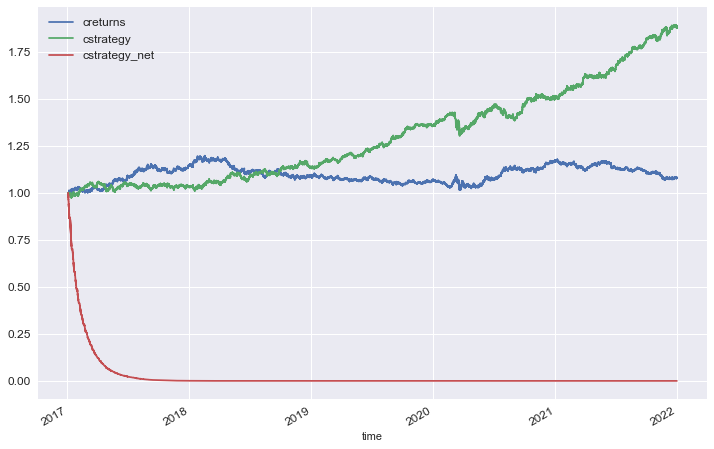

In [84]:
dataset[['creturns', 'cstrategy', 'cstrategy_net']].plot(figsize = (12,8), fontsize =12)
plt.legend(fontsize = 12)
plt.show()